In [3]:
# Step 1: Install and initialize PySpark
!pip install pyspark
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("CellulantTransactionAnalysis").getOrCreate()

In [5]:
# Step 2: Dataset Upload
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Step 3: Data Loading
df = spark.read.csv('drive/My Drive/Colab Notebooks/synthetic_mobile_money_transactions.csv',inferSchema=True, header =True)
df.head()

Row(step=0, transactionType='PAYMENT', amount=579.16, initiator=4018807983755588, oldBalInitiator=29.32, newBalInitiator=29.32, recipient='30-0000345', oldBalRecipient=0.0, newBalRecipient=0.0, isFraud=0)

In [7]:
# Step 4: Exploration
print("Dataset Schema:")
df.printSchema()

Dataset Schema:
root
 |-- step: integer (nullable = true)
 |-- transactionType: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- initiator: long (nullable = true)
 |-- oldBalInitiator: double (nullable = true)
 |-- newBalInitiator: double (nullable = true)
 |-- recipient: string (nullable = true)
 |-- oldBalRecipient: double (nullable = true)
 |-- newBalRecipient: double (nullable = true)
 |-- isFraud: integer (nullable = true)



In [8]:
print("\nFirst 5 Rows:")
df.show(5)


First 5 Rows:
+----+---------------+------+----------------+---------------+---------------+----------------+---------------+---------------+-------+
|step|transactionType|amount|       initiator|oldBalInitiator|newBalInitiator|       recipient|oldBalRecipient|newBalRecipient|isFraud|
+----+---------------+------+----------------+---------------+---------------+----------------+---------------+---------------+-------+
|   0|        PAYMENT|579.16|4018807983755588|          29.32|          29.32|      30-0000345|            0.0|            0.0|      0|
|   0|       TRANSFER| 39.03|4610593854752035|          39.03|            0.0|4944921135715488|          55.94|          94.98|      1|
|   0|       TRANSFER| 21.78|4840578447365454|          21.78|            0.0|4305579785620656|          58.09|          79.88|      1|
|   0|        PAYMENT|570.22|4958066799829630|           5.29|           5.29|      00-0000388|            0.0|            0.0|      0|
|   0|        PAYMENT| 574.8|4149

In [9]:
# Step 5: Data Cleaning
df_clean = df.na.drop(subset=["transactionType", "amount"])

In [10]:
# Step 6: Analysis
# Register the DataFrame as a temporary view
df_clean.createOrReplaceTempView("transactions")

In [33]:
from pyspark.sql.functions import lit, rand, col, when

# List of common payment methods
payment_methods = [
    "Mobile Money", "Bank Transfer", "Card Payment", "Cash"
]

# Add a random column to the DataFrame (you can use the existing df_with_country or a new one)
df_temp_payment = df_with_country.withColumn("random_value_payment", rand())

# Start building the 'when' conditions for payment methods
payment_method_expr = when(col("random_value_payment") < 1/len(payment_methods), payment_methods[0])

# Add the remaining conditions in a loop
for i in range(1, len(payment_methods)):
    payment_method_expr = payment_method_expr.when(col("random_value_payment") < (i+1)/len(payment_methods), payment_methods[i])

# Add the 'payment_method' column using the constructed expression
df_with_payment_method = df_temp_payment.withColumn("payment_method", payment_method_expr)

# Drop the temporary random_value_payment column
df_with_payment_method = df_with_payment_method.drop("random_value_payment")

# Show the schema to see the new 'payment_method' column
print("Dataset Schema with 'payment_method' column:")
df_with_payment_method.printSchema()

# Show a few rows to see the added column
print("\nFirst 10 Rows with 'payment_method' column:")
df_with_payment_method.show(10)

Dataset Schema with 'payment_method' column:
root
 |-- step: integer (nullable = true)
 |-- transactionType: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- initiator: long (nullable = true)
 |-- oldBalInitiator: double (nullable = true)
 |-- newBalInitiator: double (nullable = true)
 |-- recipient: string (nullable = true)
 |-- oldBalRecipient: double (nullable = true)
 |-- newBalRecipient: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- payment_method: string (nullable = true)


First 10 Rows with 'payment_method' column:
+----+---------------+--------+----------------+---------------+---------------+----------------+---------------+---------------+-------+-------------------+--------------+
|step|transactionType|  amount|       initiator|oldBalInitiator|newBalInitiator|       recipient|oldBalRecipient|newBalRecipient|isFraud|            country|payment_method|
+----+---------------+--------+------------

In [37]:
# SQL Calculation
# Register the DataFrame with the 'payment_method' column as a temporary view
df_with_payment_method.createOrReplaceTempView("transactions")

payment_volume = spark.sql("""
    SELECT payment_method, SUM(Amount) as TotalAmount
    FROM transactions
    GROUP BY payment_method
    ORDER BY TotalAmount DESC
""")
payment_volume.show()

+--------------+--------------------+
|payment_method|         TotalAmount|
+--------------+--------------------+
| Bank Transfer|6.112650164580582...|
|  Card Payment|5.486711261479285E10|
|          Cash|5.472437830061027E10|
|  Mobile Money|5.334818418161495E10|
+--------------+--------------------+



In [38]:
from pyspark.sql.functions import lit, rand, col, when

# List of 18 African countries
african_countries = [
    "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso",
    "Burundi", "Cameroon", "Central African Republic", "Chad",
    "Comoros", "Congo (Brazzaville)", "Congo (Kinshasa)", "Cote d'Ivoire",
    "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Ethiopia"
]

# Add a random column to the DataFrame
df_temp = df.withColumn("random_value", rand())

# Start building the 'when' conditions
country_expr = when(col("random_value") < 1/18, african_countries[0])

# Add the remaining conditions in a loop
for i in range(1, len(african_countries)):
    country_expr = country_expr.when(col("random_value") < (i+1)/18, african_countries[i])

# Add the 'country' column using the constructed expression
df_with_country = df_temp.withColumn("country", country_expr)

# Drop the temporary random_value column as it's no longer needed
df_with_country = df_with_country.drop("random_value")

# Show the schema to see the new 'country' column
print("Dataset Schema with 'country' column:")
df_with_country.printSchema()

# Show a few rows to see the added column with different countries
print("\nFirst 5 Rows with 'country' column:")
df_with_country.show(10)


Dataset Schema with 'country' column:
root
 |-- step: integer (nullable = true)
 |-- transactionType: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- initiator: long (nullable = true)
 |-- oldBalInitiator: double (nullable = true)
 |-- newBalInitiator: double (nullable = true)
 |-- recipient: string (nullable = true)
 |-- oldBalRecipient: double (nullable = true)
 |-- newBalRecipient: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- country: string (nullable = true)


First 5 Rows with 'country' column:
+----+---------------+--------+----------------+---------------+---------------+----------------+---------------+---------------+-------+-------------------+
|step|transactionType|  amount|       initiator|oldBalInitiator|newBalInitiator|       recipient|oldBalRecipient|newBalRecipient|isFraud|            country|
+----+---------------+--------+----------------+---------------+---------------+----------------+---------------+---------------+-----

In [39]:
# sql Calculation 2
country_volume = spark.sql("""
    SELECT Country, SUM(Amount) as TotalAmount
    FROM transactions
    GROUP BY Country
    ORDER BY TotalAmount DESC
""")
country_volume.show()

+--------------------+--------------------+
|             Country|         TotalAmount|
+--------------------+--------------------+
|        Burkina Faso|1.431395600721884...|
|            Botswana|1.409228699827908...|
|            Ethiopia|1.408253207670894...|
|               Benin|1.387938316443882E10|
|             Eritrea|1.351344479768894...|
|Central African R...|1.335957195182883...|
|            Djibouti|1.325777255131875...|
|             Comoros|1.285165931138906...|
|               Egypt|1.283094922135915...|
|             Algeria|1.240561927884945...|
|    Congo (Kinshasa)|1.221270991918918...|
|   Equatorial Guinea|1.207964566102934...|
|            Cameroon|1.170401134544954...|
|       Cote d'Ivoire|1.141938351593938E10|
|                Chad|1.102966880856942...|
| Congo (Brazzaville)|1.080477483222952...|
|             Burundi|1.032054887466956E10|
|              Angola| 9.908258426609482E9|
+--------------------+--------------------+



In [40]:
# Step 7: Spark to Pandas
payment_pd = payment_volume.toPandas()
country_pd = country_volume.toPandas()

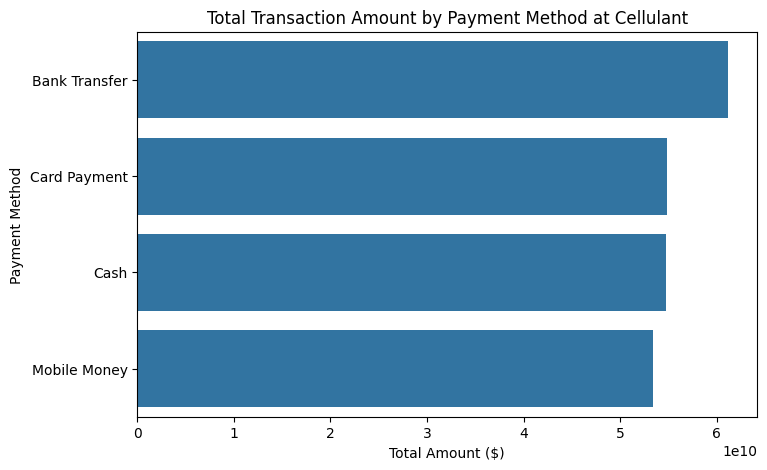

In [42]:
# Step 8: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x="TotalAmount", y="payment_method", data=payment_pd)
plt.title('Total Transaction Amount by Payment Method at Cellulant')
plt.xlabel('Total Amount ($)')
plt.ylabel('Payment Method')
plt.savefig('payment_method_volume_spark.png')
plt.show()

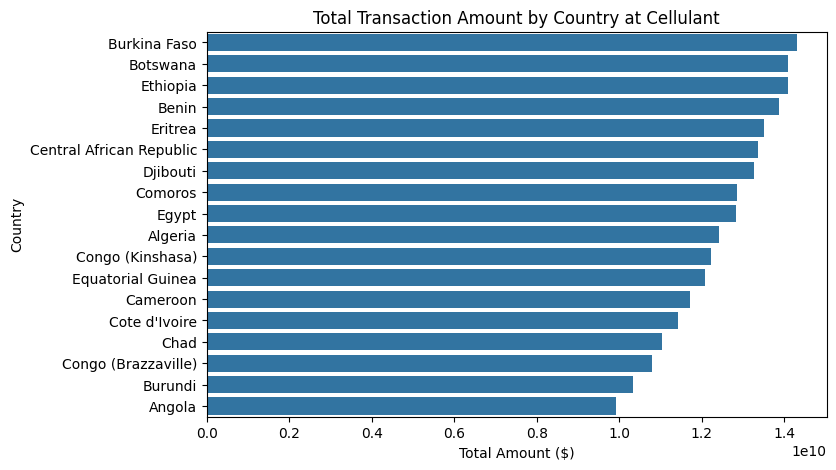

In [43]:
plt.figure(figsize=(8, 5))
sns.barplot(x="TotalAmount", y="Country", data=country_pd)
plt.title('Total Transaction Amount by Country at Cellulant')
plt.xlabel('Total Amount ($)')
plt.ylabel('Country')
plt.savefig('country_volume_spark.png')
plt.show()

In [44]:
spark.stop()